In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators
import scienceplots
from glob import glob
from tools import get_best_model,get_predictions_per_subset,mertens
import os
from scipy.stats import norm
plt.style.use(["science"])
from copy import deepcopy as cp

### Referee 1 wanted to see where the info was coming from so lets permutate the test set

In [3]:
model_name = 'simple'
simulationNames = ['CDM','SIDM1','SIDM0.1']
channels=['total','stellar','xray']
random_state=0
epochs=10

In [8]:

    
_,_,allparams =      getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=channels, 
                                                      allDataFile='pickles/binned_data_20.pkl', 
                                                      random_state=random_state, return_test_params=True, train_split=0.01)
    
train, test, params = getGenerators(augment_data=True, simulationNames=['CDM'], 
                                                      channels=channels, 
                                                      allDataFile='pickles/binned_data_20_newseed.pkl', 
                                                      random_state=random_state, return_test_params=True, train_split=0.01)   
checkpoint_filepath = 'models/%s/%i' % (model_name, random_state)
  
model = get_best_model( train, test, base_cnn_input_shape=test[0][0].shape, model_name=model_name, 
                               checkpoint_filepath=checkpoint_filepath, epochs=epochs)

Found Model


In [31]:
nBins=15
this_accuracy = []
mass_bins = np.linspace(14,15.5,nBins+1)
bin_centres = 0.5*(mass_bins[1:]+mass_bins[:-1])
nImages = params['mass'].shape[0]
nperbin = np.floor(nImages/nBins)
ntrainhalos = []
for iBin in range(nBins):
    
    start = int(iBin*nperbin)
    end = int(np.min([(iBin+1)*nperbin, nImages]))
    
    bin_idxs = np.argsort( params['mass'] )[start:end]
    
    bin_centres[iBin] = np.mean(params['mass'][bin_idxs])
    
    inBin = (allparams['mass'] > np.min(params['mass'][bin_idxs])) & (allparams['mass'] < np.max(params['mass'][bin_idxs]))
   
    ntrainhalos.append(allparams['mass'][inBin].shape)
    
    #bin_idxs = np.arange(nImages)[ inBin ]
    print(bin_idxs.shape)
    these_images = cp( test[0] )
    for idx in bin_idxs:
        these_images[idx] = np.random.uniform(these_images[idx].shape)
    this_accuracy.append(model.evaluate( these_images, test[1])[1])
    
this_accuracy = np.array(this_accuracy)
this_accuracy /= np.mean(this_accuracy)
ntrainhalos = np.array(ntrainhalos)

(30,)
15/15 [==============================] - 0s 9ms/step - loss: 670.5687 - accuracy: 0.6891
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 765.1416 - accuracy: 0.6913
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 736.4305 - accuracy: 0.6826
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 817.3351 - accuracy: 0.6870
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 700.7772 - accuracy: 0.6848
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 615.9091 - accuracy: 0.6913
(30,)
15/15 [==============================] - 0s 10ms/step - loss: 731.1368 - accuracy: 0.6957
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 836.4416 - accuracy: 0.6957
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 734.9482 - accuracy: 0.6935
(30,)
15/15 [==============================] - 0s 9ms/step - loss: 776.9028 - accuracy: 0.6826
(30,)
15/15 [==============================] - 0s

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/mass_importance.pdf'.


0

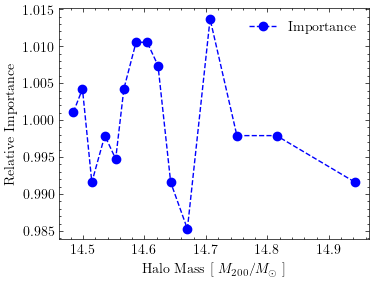

In [32]:

fig = plt.figure(figsize=(4,3))
ax = plt.gca()
#ax2 = ax.twinx()
lns1 = ax.plot(bin_centres,this_accuracy,'o', ls='--', c='b',label='Importance')
#lns2 = ax2.plot(bin_centres,ntrainhalos/np.sum(ntrainhalos),'o', ls='--',c='g', label='Represenatation')
ax.set_xlabel(r"Halo Mass [ $M_{200} / M_\odot$ ]")
ax.set_ylabel("Relative Importance")
#ax2.set_ylabel("Relative Representation")
ax.grid(False)
#ax2.grid(False)

lns = lns1#+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

savefile = '../plots/mass_importance.pdf'
plt.savefig(savefile)
os.system("pdfcrop %s %s" % (savefile,savefile))

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/mass_importance_corr.pdf'.


0

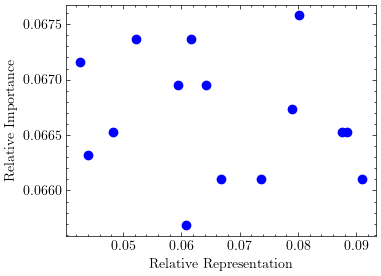

In [26]:

fig = plt.figure(figsize=(4,3))
ax = plt.gca()
lns1 = ax.plot(ntrainhalos/np.sum(ntrainhalos),this_accuracy,'o', c='b',label='Importance')
ax.set_ylabel("Relative Importance")
ax.set_xlabel("Relative Representation")
ax.grid(False)
ax2.grid(False)

savefile = '../plots/mass_importance_corr.pdf'
plt.savefig(savefile)
os.system("pdfcrop %s %s" % (savefile,savefile))

### This is old stuff and not needed for the paper

In [4]:
attributes = ['redshift']
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexesMass', testTrainSplit=0.15, attributes=attributes, massCut=14.5)
test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    #iAtt = np.array([ testSets[i][j] for j in attributes]).T
    iAtt =  testSets[i]['redshift']
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
        test_att = iAtt
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        test_att = np.append(test_att, iAtt)

593
nTests is 88
599
nTests is 89
487
nTests is 73
514
nTests is 77


593
nTests is 88
599
nTests is 89
487
nTests is 73
514
nTests is 77
LABELS ARE  [0. 1. 2. 3.]
Learning Rate 0.00100
Epoch 1/15
59/59 [==============================] - 16s 230ms/step - loss: 2.3644 - accuracy: 0.3385 - val_loss: 1.1587 - val_accuracy: 0.4373
Epoch 2/15
59/59 [==============================] - 12s 211ms/step - loss: 0.8996 - accuracy: 0.6085 - val_loss: 1.3366 - val_accuracy: 0.4006
Epoch 3/15
59/59 [==============================] - 12s 210ms/step - loss: 0.5520 - accuracy: 0.7866 - val_loss: 1.3488 - val_accuracy: 0.5352
Epoch 4/15
59/59 [==============================] - 12s 212ms/step - loss: 0.2398 - accuracy: 0.9242 - val_loss: 2.0710 - val_accuracy: 0.4343
Epoch 5/15
59/59 [==============================] - 12s 211ms/step - loss: 0.1154 - accuracy: 0.9629 - val_loss: 2.2103 - val_accuracy: 0.4587
Epoch 6/15
59/59 [==============================] - 13s 213ms/step - loss: 0.0641 - accuracy: 0.9833 - val_loss: 2.4744 - val_accuracy: 0.4709
Epoch 7/15
59/59 [========

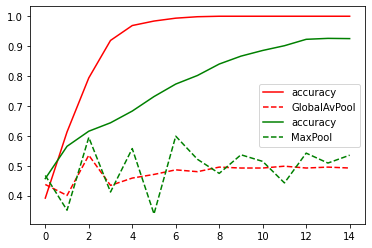

In [6]:
attributes = ['redshift']
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexesMass', testTrainSplit=0.15, attributes=attributes, massCut=14.5)
test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    iAtt = np.array([ testSets[i][j] for j in attributes]).T
    #iAtt =  testSets[i]['redshift']
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
        test_att = iAtt
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        test_att = np.vstack((test_att, iAtt))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = train_att.shape[1]

color=['r','g','b','c']

#Test the momentum on reliability
csv_file = 'pickles/massCut_14.5.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/massCut_14.5.h5'

if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=nAttributes, \
                               momentum=0.9, finalLayer=256)
    
history = model.fit([train_images, train_att], train_labels, epochs=15, 
                    initial_epoch=initial_epoch,
                    validation_data=([test_images, test_att], test_labels),
                       callbacks=csv_logger)
    
model.save(model_file)
trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
     
plt.plot(trainHistory['accuracy'], label='accuracy', color=color[0])
plt.plot(trainHistory['val_accuracy'], label = 'GlobalAvPool', linestyle='--', color=color[0]) 
    
    

csv_file =  'pickles/testDropOut_0.00_finalLayer_256.csv'
trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
     
plt.plot(trainHistory['accuracy'], label='accuracy', color=color[1])
plt.plot(trainHistory['val_accuracy'], label = 'MaxPool', linestyle='--', color=color[1]) 

plt.legend()


593
nTests is 148
599
nTests is 149
487
nTests is 121
514
nTests is 128
Learning Rate 0.00100
Epoch 8/15
52/52 [==============================] - 12s 221ms/step - loss: 3.0425 - accuracy: 0.3459 - val_loss: 1.2119 - val_accuracy: 0.3864
Epoch 9/15
52/52 [==============================] - 11s 220ms/step - loss: 1.0418 - accuracy: 0.5512 - val_loss: 1.1348 - val_accuracy: 0.5256
Epoch 10/15
52/52 [==============================] - 11s 220ms/step - loss: 0.6973 - accuracy: 0.7115 - val_loss: 1.3573 - val_accuracy: 0.4634
Epoch 11/15
52/52 [==============================] - 11s 221ms/step - loss: 0.4048 - accuracy: 0.8377 - val_loss: 1.4198 - val_accuracy: 0.5220
Epoch 12/15
52/52 [==============================] - 11s 220ms/step - loss: 0.1632 - accuracy: 0.9454 - val_loss: 2.5270 - val_accuracy: 0.3846
Epoch 13/15
52/52 [==============================] - 11s 221ms/step - loss: 0.1190 - accuracy: 0.9588 - val_loss: 1.8448 - val_accuracy: 0.4560
Epoch 14/15
52/52 [=========================

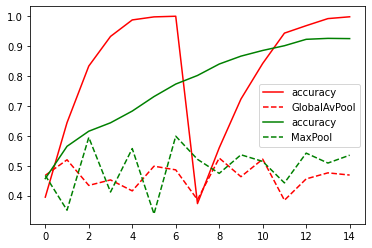

In [12]:
attributes = []
(train_images, train_att, train_labels), testSets = \
        getData(  indexFileRoot='pickles/testIndexesMass', testTrainSplit=0.25, attributes=attributes, massCut=14.5)
test_labels, test_images, test_att = None, None, None
for i in testSets.keys():
    iAtt = np.array([ testSets[i][j] for j in attributes]).T
    #iAtt =  testSets[i]['redshift']
    if test_labels is None:
        test_images = testSets[i]['images']
        test_labels = testSets[i]['labels']
        test_att = iAtt
    else:
        test_labels = np.vstack((test_labels, testSets[i]['labels']))
        test_images = np.vstack((test_images, testSets[i]['images']))
        test_att = np.vstack((test_att, iAtt))
        
nClasses = len(np.unique(train_labels))
inputShape = train_images.shape[1:]
nAttributes = 0#train_att.shape[1]

color=['r','g','b','c']

#Test the momentum on reliability
csv_file = 'pickles/massCut_14.5_noAtt.csv'
csv_logger = CSVLogger(csv_file, append=True)
model_file =  'pickles/massCut_14.5_noAtt.h5'

if os.path.isfile( csv_file ):
    previousEpochs = np.loadtxt( csv_file, delimiter=',',skiprows=1 )
    initial_epoch = previousEpochs.shape[0]
else:
    initial_epoch = 0
        
if os.path.isfile(model_file):
    print("FOUND PREVIOUS MODEL, LOADING...")
    model = models.load_model(model_file)
else:
    model = simpleCNN.getModel( inputShape, nClasses, nAttributes=nAttributes, \
                               momentum=0.9, finalLayer=256)
    
history = model.fit(train_images, train_labels, epochs=15, 
                    initial_epoch=initial_epoch,
                    validation_data=(test_images, test_labels),
                       callbacks=csv_logger)
    
model.save(model_file)
trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
     
plt.plot(trainHistory['accuracy'], label='accuracy', color=color[0])
plt.plot(trainHistory['val_accuracy'], label = 'GlobalAvPool', linestyle='--', color=color[0]) 
    
    

csv_file =  'pickles/testDropOut_0.00_finalLayer_256.csv'
trainHistory = np.loadtxt( csv_file, delimiter=',', 
                    dtype=[('epoch', object), ('accuracy', float), 
                    ('loss', float), ('val_accuracy',float),('val_loss', float)], skiprows=1)
     
plt.plot(trainHistory['accuracy'], label='accuracy', color=color[1])
plt.plot(trainHistory['val_accuracy'], label = 'MaxPool', linestyle='--', color=color[1]) 

plt.legend()
